In this notebook I use 70000 images of handwritten digits from the mnist dataset with tensorflow's Keras API to build, train, validate and evaluate the model performance. The mnist dataset is a very important and easy to acess dataset for the deep learning beginners. Building a deep learning program using mnist dataset is considered the equivalent of writing "Hello World" in any other programming languages. This is probably a widespread and higly used data set in this area. By using the Keras API with Tensorflow, this dataset is just a step away from a click of our fingertip.

**Objectives**<br><br>
step 1 : Load the mnist dataset with tensorflow's Keras API<br><br>
         Before even start building a machine learning or deep learning model, it is important to have data. Building a very nice model without knowing the whereabouts of the data is the same as having a very elegant car but without clue of petrol. In this example I explore the very famous handwritten digit data and this is very easy to access with the tensorflow's Keras API as <b>from tensorflow.keras.datasets import mnist</b> and then <b>mnist.load_data()</b>. This is done in load_data() function.

step 2 : Reshape, convert datatype, and normalize data<br></br>
         Below there is a function call <b>preprocess_train_test()</b> dedicated to the preprocessing of training data. There are three main processes that happen. The first (60000,28,28) form of the training data is transformed to (60000,28,28,1) by adding an extra dimension for the color channel. In this example the images are in grayscale, which means that only one color channel is used, as a result 1 is added. In the case of a color image, this value would have been 3 for Red-Green-Blue (RGB) channels. The Reshape method is used for this action.<br></br>         
The pixel values in data obtain from mnist are given as integer which are changed to floating using .astype() method.<br></br>         
And lastly, the pixel values are rescaled from 0 to 255 to 0 to 1. In deep learning and machine learning computation, the normalization process falls under the data preprocessing step and is highly recommended and must do processed. This is especially important when the dataset has different features at different scales or feature distributions. For example, if weight and height are used to predict a person's health, then traits (weight and height) should be normalized. As a higher weight number would have a strong impact on the weight of the model and the model may give misleading results. For more information read the following article https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/ 
         
step 3 : Build a sequential model that has convolutional, maxpooling, and dense layers<br></br>

After getting data and its preproeccessing, the next step is to build a model which is done inside a function convolutional_model(). There are two convolutional layers with 16 and 32 filters and kernal size of (3,3). The maxpooling layers with pool size of (2,2) follows immediately after each covolutional layers. The convolutional filters highlight the features from an image which is later preserved by maxpooling layer. It can be seen that our input size is (28,28) but after passing it to the first convolutional layer the pixel size became (26,26) (see model summary) because one left most and one right most pixel is not accounted. Since I use (2,2) pool_size therefore it reduces the pixel size by half in each dimension. Because when (2,2) pool_size is used, one pixel with large value is choosen from 4 pixels. Therefore the pixel size of (26/2,26/2)=(13,13) or ( sqrt((26*26)/(2*2)),sqrt((26*26)/(2*2)) ) is passed to the next convolutional layer. Then there is Flatten() layers that converts NxN array into a N^2 simple linear array and one hidden layer with 128 neurons. To activate the neurons of the dense layer I use 'relu' activation function and hence each neuron of dense layer gets activated if they receive a positive number otherwise neuron don't response. In the final layer there are 10 neuron equivalent to 10 different classes (labels) in dataset. They should always match if softmax activation function is used. Due to the softmax activation function, the final prediction is given in terms of probability, and as a result, all ten classes have a non-zero value as an array. We choose the maximum value of such an array. And the model prediction is the positional index of the maximum value. For example if the model predicts digit 8 then it gives an array like [[0.17456357 0.06375998 0.09480414 0.09106188 0.03082938 0.01556196 0.08969155 0.01454732 0.4181515  0.00702876]] and we can see that the probability is maximum at the 9th place and since count starts from 0, so it is digit 8.

#We used softmax activation function in our final layer as a result 
    #prediction is made in terms of probability. Consequently all ten classes 
    #have none -zero value and we take maximum value from this array.
         

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K    
import matplotlib.pyplot as plt    
import numpy as np
import sys, time, os
import datetime 

#from skimage import img_as_ubyte
#from skimage.color import rgb2gray    

In [17]:
class MyCallback(tf.keras.callbacks.Callback):
    #This class checks if training accuracy is reached 99.5% or not in each epoch.
    #If 99.5% accuracyis achieved, model will not train further.
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('accuracy') >= 0.95:
            print(f'\n Reached 99.5% percentage of accuracy so cancelling training')
            self.model.training = True
    pass        

In [5]:
def print_function(input_):
    #This takes an input and print out
    if len(input_) == 0:
        print('  ')
    else:
        print(input_)
        


def load_data():        
    #Load mnist dataset with tensorflow's Keras API
    (x_train,y_train),(x_test,y_test) = mnist.load_data()
    return x_train,y_train,x_test,y_test

In the following code shell, the initial form of the training data (60000,28,28) and test data (10000,28,28) are transformed into (60000,28,28,1) and (10000,28,28,1) respectively. Then the pixel values 0 to 255 are rescaled to 0 to 1.  

In [7]:
def preprocess_train_test(x_train,x_test):
    #Reshape, change data type, and rescale or Normalize pixel values
    Train_Images_Size = x_train.size
    Test_Images_Size  = x_test.size

    Training_Images = x_train.shape[0]
    Test_Images     = x_test.shape[0]    

    Width_Image_Train  = int(np.sqrt(Train_Images_Size/ Training_Images))
    Height_Image_Train = Width_Image_Train

    Width_Image_Test  = int(np.sqrt(Test_Images_Size/ Test_Images))
    Height_Image_Test = Width_Image_Test        

    if  Width_Image_Train != Width_Image_Test and Height_Image_Train != Height_Image_Test:
        print_function(f' Resolution of image in train set is not the same as in test set')
        print_function(f' Image resolution in train set : {Width_Image_Train}x{Height_Image_Train} ')
        print_function(f' Image resolution in train set : {Width_Image_Test}x{Height_Image_Test} ')

    input_shape = (Width_Image_Train,Height_Image_Train,1)

    #Reshape the data to pad extra dimension for color
    x_train_ = x_train.reshape(Training_Images,Width_Image_Train,Height_Image_Train,1)
    x_test_  = x_test.reshape(Test_Images,Width_Image_Test,Height_Image_Test,1)

    #Change datatype from integer to float
    x_train_ = x_train_.astype(dtype=np.float32)
    x_test_  = x_test_.astype(dtype=np.float32)

    #Normalize the pixel values to be between 0 and 1    
    x_train_, x_test_ = x_train_/255.0, x_test_/255.0


    print_function(' ')
    print_function(f'There are {Training_Images} images to train and {Test_Images} images to test the model.')
    print_function(f'Resolution of each image {Width_Image_Train}x{Height_Image_Train}. ')
    print_function(f'The pixel values have been normalized and are between 0 and 1. ')
    print_function(f'Shape of training data before reshape {x_train.shape}')
    print_function(f'Shape of training data after reshape {x_train_.shape}')
    print_function(' ')
    return x_train_, x_test_, input_shape

In our dataset, the labels are given as numbers from 0 to 9. The following function 'preprocess_label_train_test()' converts each label (integer) into an array of 10 binary vector elements. For example, if the label is 5, it will be converted to [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], remember that the digit starts at 0, so 1 is in the 6th position. This process is called one hot encoding and 'tf.keras.utils.to_categorical' is used to achieve this.

In [8]:
def preprocess_label_train_test(y_train, y_test):    
    diff_classes = 10
    y_train = tf.keras.utils.to_categorical(y_train,diff_classes)
    y_test  = tf.keras.utils.to_categorical(y_test,diff_classes)  
    return y_train, y_test

In the following code, a convolutional neural network is built. Two layers of convolution, two layers of maxpooling, two layers of dropout and one hidden layer with 256 nodes are used in the model. Convolutionla layers highlight the important features of our images, and maxpooling layers extract such highlight features. Dropout layers randomly disconnect some neurons and are used to prevent the overfitting problem. And nodes of dense layers are activated when they get a positive number (the product of pixel value and weight is positive) because I'm using the relu activation function.

In [9]:
def convolutional_model():
    #Create the model architecture 
    model = Sequential()
    model.add( Conv2D(filters=16, 
                      kernel_size=(3,3),
                      activation=tf.nn.relu, 
                      input_shape=(28,28,1) ) )
    model.add( MaxPooling2D( pool_size=(2,2) ) )
    model.add( Conv2D(filters=32,
                      kernel_size=(3,3),
                      activation=tf.nn.relu) )
    model.add( MaxPooling2D( pool_size=(2,2)))
    model.add( Dropout(0.3) )
    model.add( Flatten() )
    model.add( Dense(256,activation=tf.nn.relu) )
    model.add( Dropout(0.3) )
    #model.add( Dense(128,activation=tf.nn.relu))
    #model.add( Dropout(0.3))
    model.add( Dense(10,activation=tf.nn.softmax))
    
    model.summary()
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

The train model will be saved with the name specified by the user, and if no name is specified, it will be saved with today's date and time. The user is notified under which name the model and the history of the model are saved.

In [32]:
def save_model_history(model,history,answer):
    if len(answer) > 3:
        model_name   = answer+'.h5'
        history_name = answer+'.npy'
        
        #Save model for later use
        model.save(model_name)
        
        #Save train history with loss and accuracy for later use
        np.save(history_name,history)
        
        print_function('')
        message = f'Model and history are saved in {model_name} and {history_name} files.'
        print_function('')
        print_function(message)
    elif len(answer) == 0 and len(answer) == 3:
    #
        year    = datetime.date.today().year
        month   = datetime.datetime.today().strftime('%B')
        day     = datetime.datetime.today().strftime('%A')
        hour    = datetime.datetime.today().strftime('%H')
        minate  = datetime.datetime.today().strftime('%M')
        second  = datetime.datetime.today().strftime('%S')
                
        model_name   = str(year)+'_'+str(month)+'_'+str(day)+'_'+str(hour)+'_'+str(minate)+'_'+str(second)+'.h5'
        history_name = str(year)+'_'+str(month)+'_'+str(day)+'_'+str(hour)+'_'+str(minate)+'_'+str(second)+'.npy'
    else:
        return
    
    #Save model for later use
    model.save(model_name)
    #Save train history with loss and accuracy for later use
    np.save(history_name,history)    
    
    message = f'Model and history are saved in {model_name} and {history_name} files.'
    print_function('')
    print_function(message)
    
    return model_name

Below is training the model and calling the save_model_history() function to save it.

In [28]:
def train_model(given_input):
    if not os.path.splitext(given_input)[-1] == '.npy':
                        
        #Invoke callback method
        callbacks = MyCallback()    
    
    #Build model
    if os.path.splitext(given_input)[-1] == '.h5':
        #preprocess data
        x_train,y_train,x_test,y_test = load_data()
        x_train,x_test, input_shape   = preprocess_train_test(x_train,x_test)
        y_train, y_test               = preprocess_label_train_test(y_train, y_test)                       
        model = load_model_later(given_input)
        #make epoch number less for second time or
        #just leave it because we have callback function
        
        #Train model again
        time_init    = time.time()
        history      = model.fit(x_train,y_train,batch_size=128,epochs=10,validation_data=(x_test,y_test),callbacks=[callbacks])     
        time_final   = time.time()    
        time_taken   = time_final-time_init  
    elif os.path.splitext(given_input)[-1] == '.npy':
        history = load_hist(given_input)
        plot_loss_And_accuracy(history)
        return
    else:
        print_function('Are sure about trainig the model from the scratch?')
        answer = input('')
        #preprocess data
        x_train,y_train,x_test,y_test = load_data()
        x_train,x_test, input_shape   = preprocess_train_test(x_train,x_test)
        y_train, y_test               = preprocess_label_train_test(y_train, y_test)                       
        if len(answer) == 0:
            model = convolutional_model()
            #Train model from scratch 
            time_init    = time.time()
            history      = model.fit(x_train,y_train,batch_size=128,epochs=10,validation_data=(x_test,y_test),callbacks=[callbacks])     
            time_final   = time.time()    
            time_taken   = time_final-time_init                
    
    message = f'{round(time_taken,2)} second is required to train the model.'
    print_function('')
    print_function(message)
    print_function('')
    
    #Training accuracy versus validatio accuracy
    plot_loss_And_accuracy(history)
    #Training loss versus validation loss
    #plot_loss(history)
    
    #Save both the history and model for later use
    answer = input('Do you want to save the model?(yes => give a name /no => enter)\n')    
    model_name = save_model_history(model,history,answer)
    return model_name    

In [13]:
def load_hist(given_input):
    history = np.load(given_input,allow_pickle='TRUE').item()
    return history

def load_model_later(given_input):
    #This loads a model from disk. When loading the model, compile=True (default) is 
    #required because the model needs to be compiled before training or testing
    model = load_model(given_input,compile=True)
    return model

The following function is used to plot training loss and validation loss, and training accuracy and validation accuracy. I plot them side by side using matplotlib's subplot method. To avoid overlapping two graphs, 'plt.tight_layout()' is used.

In [14]:
def plot_loss_And_accuracy(history):    

    fig = plt.figure(figsize=(10,6))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'],marker='o',label='Train accuracy')
    plt.plot(history.history['val_accuracy'],marker='o',label='val_accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')  
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'],marker='o',label='Train loss')
    plt.plot(history.history['val_loss'],marker='o',label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend(loc='lower right');    
     
    plt.tight_layout() 
    plt.show()                

The code below uses the cv2 model to capture images or video from a webcam. First it checks whether the webcam is open or not. The canvas size of videos is reconfigured via video.set. Since the images displayed in the webcam are color images, I first convert them to grayscale and rescale them to the 28x28 pixel values. And finally, what value the model predicts, write on the screen where the video is displayed. Most of the following lines of code are used to convert captured images into a suitable format to feed the model.

In [15]:

def live_demo(given_answer):
    import cv2
    model = load_model_later(given_answer)
    video = cv2.VideoCapture(0)
    
    
    #video = cv2.VideoCapture('output.mp4')
    if (video.isOpened() == False):
        print_function('Error while opening the video file')
    
    t0 = time.time() 
    while (video.isOpened()):
        width  = 640
        height = 480
        video.set(3,width)
        video.set(4,height)
        fps         = video.get(cv2.CAP_PROP_FPS)
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
        
        log, img = video.read()
        if log == True:
            img_gray            = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            img_gray_unit8      = cv2.convertScaleAbs(img_gray)
            threshold,im_binary = cv2.threshold(img_gray_unit8,128,255,cv2.THRESH_BINARY)
            img_resized         = cv2.resize(im_binary,(28,28))
            im_invert_gray      = 255- img_resized
            #cv2.imshow('Inverted Image', im_invert_gray)
            im_final            = im_invert_gray.reshape(1,28,28,1)
            predicted_result    = model.predict(im_final)            
            predicted_result    = np.argmax(predicted_result,axis=1)[0]
            
            org = (50,50)
            fontScale=1
            color=(255,0,0)
            thickness=2
            cv2.putText(img,'Predicted:'+str(predicted_result),org,cv2.FONT_HERSHEY_SIMPLEX,fontScale,color,thickness,cv2.LINE_AA)
            cv2.imshow('Original Image',img)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            t1 = time.time()
            time_now = t1-t0
            #if time_now > 3: sys.exit()
        else:
            message = ' Video can"t be read. '
            print_function(message)
            break
        
    video.release()
    cv2.destroyAllWindows()    

The following code controls the user preferences. A number of questions are asked, on the basis of which the various measures are taken. In short, the first code searches whether or not there are already trained models. If present, the user will be asked if they agree. If not, the model is trained from scratch. It is also possible to train and continue training models already used. As soon as the code goes through the question asked, it will delete what to do. There is an option to make a prediction in a live video and for this option option 2 should be selected. Users are asked if they want to use an already trained model or train a new model first. If no answer is given, the program understands that the user wants to train the model first and use this model to make a prediction in a live video. To avoid multiple questions, just run train_model(''), this will do the job

There is/are 9 already trained model in the current directory. They are 
['2022_July_Sunday_11_12_43.h5', 'Handwritten_Digit_Reco_Model_with_2DenseLayers.h5', '2022_July_Monday_22_50_31.h5', '2022_July_Sunday_03_09_10.h5', '2022_July_Sunday_03_07_07.h5', 'Handwritten_1DenseLayers256_2Conv2D_History.h5', '2022_July_Monday_22_48_25.h5', '2022_July_Monday_23_20_51.h5', 'Handwritten_Digit_Reco_Model.h5']
 
(1) Do you want to use already trained model for further training?
(2) Do you want to make a prediction in a live video?  
(3) Do you want to train from the scratch?     
(4) Just want to plot loss and accuracy of old model. 
(5) Make a prediction for a selected image. 
  
Please choose from the above options.
1
  
Answer is noted and 2022_July_Sunday_11_12_43.h5 is going to be used.
  
Do you want another model to use?(yes/no)

 
There are 60000 images to train and 10000 images to test the model.
Resolution of each image 28x28. 
The pixel values have been normalized and are between 0 an

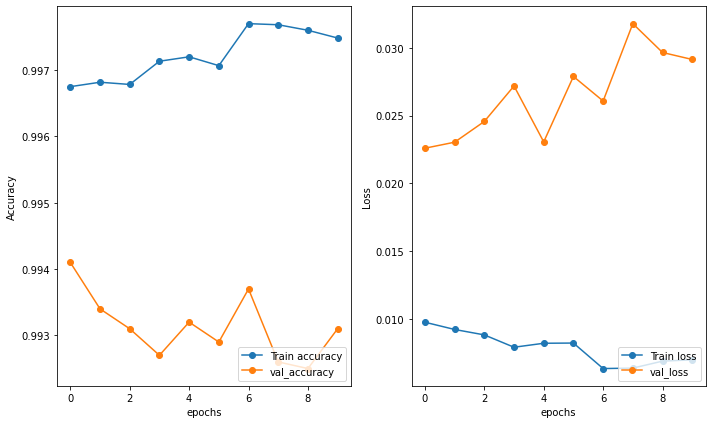

In [ ]:
if __name__=='__main__':
    files       = os.listdir()
    saved_model = []
    counter     = 0
    for item in files:                
        if os.path.splitext(item)[-1] == '.h5':
            counter += 1
            saved_model.append(item)
            
    if counter != 0:                
        print_function(f'There is/are {counter} already trained model in the current directory. They are ')
        print_function(saved_model)
        print_function(' ')
        print_function(f'(1) Do you want to use already trained model for further training?')
        print_function(f'(2) Do you want to make a prediction in a live video?  ')
        print_function(f'(3) Do you want to train from the scratch?     ')
        print_function(f'(4) Just want to plot loss and accuracy of old model. ')
        print_function(f'(5) Make a prediction for a selected image. ')
        print_function('')
        
        answer = input('Please choose from the above options.\n')
        print_function('')
        
        #If option 1 or any file name with .h5 extension is given 
        #then model is going to trained with already trained model
        if os.path.splitext(answer)[-1] == '.h5' or answer == '1':            
            #If name of the file is given
            if answer !='1':
                message = f'Answer is noted and {answer} is going to be used.'
                print_function(message)
                train_model(answer)
                
            #If option 1 is chosen, automatically the first file from save_model list will be choosen
            #Users are asked to confirm or ammend the option.
            else:
                message = f'Answer is noted and {saved_model[0]} is going to be used.'
                print_function(message)
                print_function('')
                answer = input('Do you want another model to use?(yes/no)\n')
                
                #Compile with automatically choosed option
                if answer == 'no' or answer == 'No' or len(answer) == 0:
                    train_model(saved_model[0])
                    
                #If a change wanting to be made type yes or enter    
                elif answer == 'yes' or len(answer) == 0:
                    new_name = input('Give the name of the file?\n')
                    train_model(new_name)
                else:
                    sys.exit()
                    
       #If we want prediction on live video then choose option 2            
        elif answer == '2':
            print_function('')
            answer2 = input('Which model to use from the above list?\n')
            list_of_model = os.listdir()
            counter = 0
            for item in list_of_model:
                if os.path.splitext(item)[-1] == '.h5':
                    counter += 1
                    
            if len(answer2) != 0 and counter != 0:
                live_demo(answer2)         
            else:
                model_name = train_model('')
                live_demo(model_name)
                                            
        elif answer == '3':                                    
            train_model('train_from_scratch')  
        elif answer == '4':
            all_files     = os.listdir()
            history_files = [] 
            for item in all_files:
                if os.path.splitext(item)[-1] == '.npy':
                    history_files.append(item)
            print('Please choose from the following list.')
            print(history_files)
            print_function('')
            choice = input()
            train_model(choice)
            
        elif answer == '5':
            from model_evaluation import predictOn_new_image
            predictOn_new_image()
        elif len(answer) == 0:
            print_function('Exit')
            pass
            
    
        #Ask how many convolutional layers user want to use and how many dense layer 
        # and run them over the loop

Given a name or the path for example image
sample_image.png


/home/kbelbase/anaconda3/lib/python3.8/site-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


1/1 [==============================] - 0s 55ms/step
The model sees the number 7 in the uploaded image.
How right I am :-)


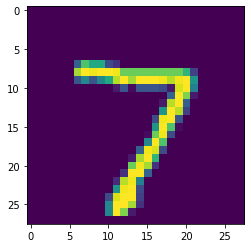

In [30]:
from model_evaluation import predictOn_new_image
predictOn_new_image();

Are sure about trainig the model from the scratch?

 
There are 60000 images to train and 10000 images to test the model.
Resolution of each image 28x28. 
The pixel values have been normalized and are between 0 and 1. 
Shape of training data before reshape (60000, 28, 28)
Shape of training data after reshape (60000, 28, 28, 1)
 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 32)       

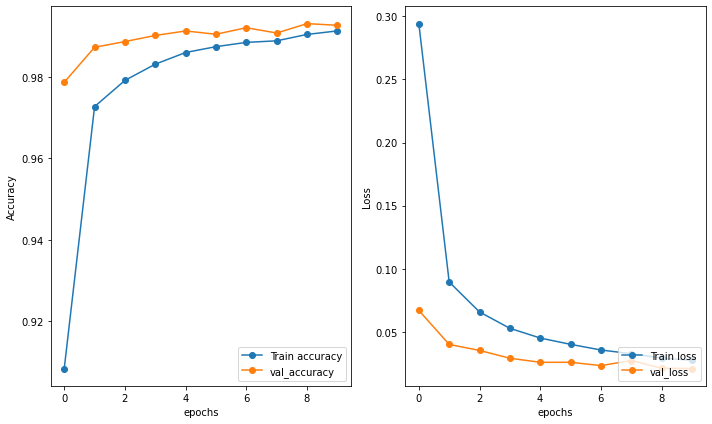

Do you want to save the model?(yes => give a name /no => enter)



INFO:tensorflow:Assets written to: ram://1e99c0d0-90f7-4a77-a08d-a3352a6c9cff/assets


INFO:tensorflow:Assets written to: ram://1e99c0d0-90f7-4a77-a08d-a3352a6c9cff/assets


  
Model and history are saved in 2022_July_Monday_23_20_51.h5 and 2022_July_Monday_23_20_51.npy files.


'2022_July_Monday_23_20_51.h5'

In [29]:
train_model('')